# Modelin Ayarlanması ve Geliştirilmesi

Bu colab dosyasında, veri işlemedeki çeşitli ince ayarların modelin kendisini ve sonuçlarını nasıl etkileyebileceğini göreceğiz. Bu ayarlamalardan sonra ağın veri kümesindeki her bir kelimenin ilgili duygularının nasıl göründüğünü bir kez daha görselleştirerek önceki modele kıyasla daha başarılı bir model elde etmeye çalışacağız.

## TensorFlow Kütüphanesinin ve Gerekli İşlevlerin İçeri Aktarılması 

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Veri Setinin Alınması

Amazon ve Yelp incelemelerini (yorumlarını) içeren veri setini bir kez daha kullanacağız. Bu veri seti orijinal olarak [buradan](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set) alınmıştır.


In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2021-07-28 11:13:09--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 172.217.15.110, 2607:f8b0:4004:811::200e
Connecting to drive.google.com (drive.google.com)|172.217.15.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ic3budi222dbrriqmf59ic1vv1rdjbb9/1627470750000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2021-07-28 11:13:09--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ic3budi222dbrriqmf59ic1vv1rdjbb9/1627470750000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 142.250.188.193, 2607:f8b0:4004:836::2001
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|142.250.188.19

In [3]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Veri Setinin Tokenize Edilmesi (Model Geliştirme Yöntemleriyle)

Şimdi, veri setini tokenize edeceğiz, ancak bunda önceden bazı değişiklikler yapabiliriz. Daha önceki modelde şunları kullandık:

```
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
```
Bu değerleri değiştirmek modeli nasıl etkileyecek gözlemleyelim.

In [4]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Duygu Analizi Modelinin Eğitilmesi (Model Geliştirme YÖntemleri İle)

Buarada biraz farklı bir model kullanacağız:
`Flatten()` yerine `GlobalAveragePooling1D` kullanalım ve modele nasıl etki göstereceğini gözlemleyelim.

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


In [6]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 4s 7ms/step - loss: 0.6928 - accuracy: 0.5122 - val_loss: 0.6938 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5518 - val_loss: 0.6938 - val_accuracy: 0.4386
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.6058 - val_loss: 0.6915 - val_accuracy: 0.4912
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.6290 - val_loss: 0.6909 - val_accuracy: 0.4887
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6240 - val_loss: 0.6842 - val_accuracy: 0.5514
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6721 - accuracy: 0.6660 - val_loss: 0.6795 - val_accuracy: 0.5514
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.7081 - val_loss: 0.6723 - val_accuracy: 0.5915
Epoch 8/30
50/50 [==

## Eğitim Sürecinin Grafik İle Görselleştirilmesi

Hiperparametrelerde ve modelde farklı ince ayarlar denerken eğitim ve doğrulama seti doğruluğunu (`accuracy`) görselleştirmek için aşağıdaki kodu kullanabilirsiniz.

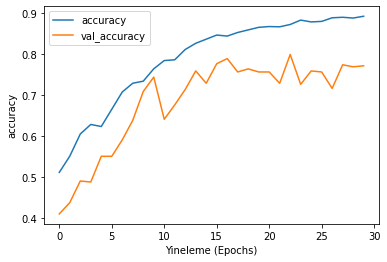

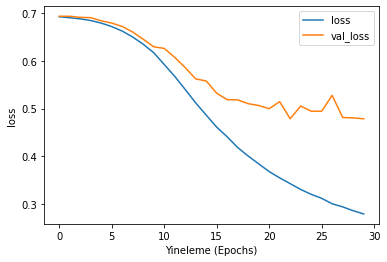

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Yineleme (Epochs)")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Ağı Görselleştirmek İçin Dosyaların Alınması

Aşağıdaki kod, ağınızın her bir kelimeyle ilgili duyguyu nasıl "gördüğünü" görselleştirmek için iki dosya indirecektir. http://projector.tensorflow.org/ adresine gidin ve bu dosyaları yükleyin, ardından verileri "küreleştirmek" için onay kutusunu tıklamayı unutmayın.

Unutmayın ! : Daha önceki `vocab_size` değişkeninizin kelime dağarcığındaki gerçek kelime sayısından daha büyük olması durumunda, projeksiyonda hatalarla karşılaşabilirsiniz, bu durumda bu değişkeni azaltmanız ve görselleştirmek için yeniden eğitmeniz gerekir.





In [10]:
# İlk önce gömme katmanının ağırlıklarını alın
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # Şekil: (vocab_size, embedding_dim)

(500, 16)


In [11]:
import io

# Ters kelime dizini oluşturun
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Gömme vektörlerini ve meta verileri yazın
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [12]:
# Dosyaları indirin
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Yeni İncelemelerle (Yorumlar) İle Duyarlılığın Tahmin Edilmesi



In [13]:
# Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head']

print(fake_reviews) 

# Dizileri oluşturun
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# Sınıf 1'e ne kadar yakınsa, inceleme o kadar olumlu kabul edilir.
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Kendi yorumlarınızı eklemeyi deneyin
# İyi incelemelere bazı olumsuz kelimeler ("değil" gibi) ekleyin ve ne olduğunu görün
# Örneğin:
# bize bedava çikolatalı kek verdiler ve bizden ücret almadılar

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[0.85951513]


I hate spaghetti
[0.16536339]


Everything was cold
[0.5379913]


Everything was hot exactly as I wanted
[0.37780374]


Everything was green
[0.5379913]


the host seated us immediately
[0.49959573]


they gave us free chocolate cake
[0.78528863]


not sure about the wilted flowers on the table
[0.09158245]


only works when I stand on tippy toes
[0.76497954]


does not work when I stand on my head
[0.03528639]


